In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
if os.path.exists("../input/rsna-miccai-brain-tumor-radiogenomic-classification"):
    data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
    pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"
else:
    data_directory = '/media/roland/data/kaggle/rsna-miccai-brain-tumor-radiogenomic-classification'
    pytorch3dpath = "EfficientNet-PyTorch-3D"
    
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 128
NUM_IMAGES = 64

sys.path.append(pytorch3dpath)
from efficientnet_pytorch_3d import EfficientNet3D

## Functions to load images

In [3]:
def Load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def Load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([Load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = Load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 128, 128, 64)
0.0 1.0 0.07992366480843072 0.00023943086165344952


In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(99)

## train / test splits

In [5]:
train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=24, 
    stratify=train_df["MGMT_value"],
)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [6]:
df_train.tail()

,BraTS21ID,MGMT_value
68,106,1
547,801,1
101,151,0
498,729,0
537,789,1


## Model and training classes

In [7]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = Load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0

            data = Load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", rotate=rotation)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out
    

In [9]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            # if True:
            # if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()

            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

## train models

In [10]:
modelfiles=['../input/final-models/FLAIR-e2-loss0.691-auc0.583.pth', '../input/final-models/T1w-e3-loss0.691-auc0.451.pth', '../input/final-models/T1wCE-e6-loss0.690-auc0.576.pth', '../input/final-models/T2w-e6-loss0.690-auc0.522.pth']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=True
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=4,
        shuffle=True,
        num_workers=8,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )

    model = Model()
    model.to(device)

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        10, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        10,
    )
    
    return trainer.lastmodel



if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

## Predict function

In [11]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

In [12]:
df_valid

,BraTS21ID,MGMT_value
481,698,1
43,66,1
437,628,1
469,683,0
325,480,1
...,...,...
236,343,0
316,464,0
342,506,1
471,685,0


## Ensemble for validation

Predict: ../input/final-models/FLAIR-e2-loss0.691-auc0.583.pth FLAIR (117, 2)
Predict: ../input/final-models/T1w-e3-loss0.691-auc0.451.pth T1w (117, 3)
Predict: ../input/final-models/T1wCE-e6-loss0.690-auc0.576.pth T1wCE (117, 3)
Predict: ../input/final-models/T2w-e6-loss0.690-auc0.522.pth T2w (117, 3)
Validation ensemble AUC: 0.5445


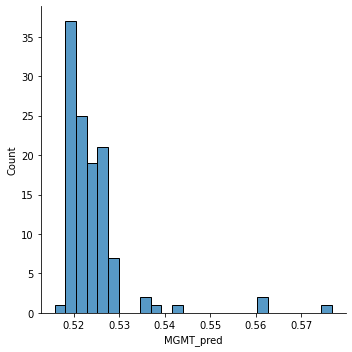

In [13]:
df_valid = df_valid.set_index("BraTS21ID")
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])

## Ensemble for submission

In [14]:

submission = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv", index_col="BraTS21ID")

submission["MGMT_value"] = 0
for m, mtype in zip(modelfiles, mri_types):
    pred = predict(m, submission, mtype, split="test")
    submission["MGMT_value"] += pred["MGMT_value"]

submission["MGMT_value"] /= len(modelfiles)
#submission["MGMT_value"].to_csv("predict.csv")

Predict: ../input/final-models/FLAIR-e2-loss0.691-auc0.583.pth FLAIR (87, 1)
Predict: ../input/final-models/T1w-e3-loss0.691-auc0.451.pth T1w (87, 2)
Predict: ../input/final-models/T1wCE-e6-loss0.690-auc0.576.pth T1wCE (87, 2)
Predict: ../input/final-models/T2w-e6-loss0.690-auc0.522.pth T2w (87, 2)


In [15]:

predict=submission['MGMT_value']
predict=pd.DataFrame(predict).reset_index(drop=False)

predict['BraTS21ID']=predict['BraTS21ID'].apply(lambda x: str(x).zfill(5))
predict=predict.set_index('BraTS21ID')
submissionDict=predict['MGMT_value'].to_dict()
submissionDict


{'00001': 0.5190382599830627,
 '00013': 0.5202355086803436,
 '00015': 0.5247491747140884,
 '00027': 0.5217148885130882,
 '00037': 0.5420118272304535,
 '00047': 0.5225080698728561,
 '00079': 0.5221379101276398,
 '00080': 0.5235393792390823,
 '00082': 0.5252706855535507,
 '00091': 0.5223283618688583,
 '00114': 0.5192570686340332,
 '00119': 0.5191342309117317,
 '00125': 0.5226651132106781,
 '00129': 0.5227869004011154,
 '00135': 0.5228004455566406,
 '00145': 0.5231781303882599,
 '00153': 0.5195670798420906,
 '00161': 0.5227221697568893,
 '00163': 0.5203731209039688,
 '00174': 0.523516446352005,
 '00181': 0.521406427025795,
 '00182': 0.5192729979753494,
 '00190': 0.5198193341493607,
 '00200': 0.5203750133514404,
 '00208': 0.5243108868598938,
 '00213': 0.5522996485233307,
 '00229': 0.5196722149848938,
 '00252': 0.5255888849496841,
 '00256': 0.5261367708444595,
 '00264': 0.5187167003750801,
 '00287': 0.5223642140626907,
 '00307': 0.5190987288951874,
 '00323': 0.5202489644289017,
 '00333': 0.

In [16]:

sub_732= pd.read_csv("../input/called0732/submission.csv")
sub_732=sub_732.sort_values(by=['BraTS21ID'], ascending=True)
sub_732=sub_732.reset_index(drop=True)
sub_732.head(3) 
sub_734= pd.read_csv("../input/sub0734/submission.csv")
sub_734=sub_734.sort_values(by=['BraTS21ID'], ascending=True)
sub_734=sub_734.reset_index(drop=True)
sub_734.head(3)  
sub_761=pd.read_csv("../input/final-miccai/submission.csv")
sub_761=sub_761.sort_values(by=['BraTS21ID'], ascending=True)
sub_761=sub_761.reset_index(drop=True)
sub_761.head(3)
Finalsubmission=sub_761.copy()
Finalsubmission['MGMT_value'] =sub_761['MGMT_value'].values*0.95+sub_734['MGMT_value'].values*0.05
Finalsubmission['BraTS21ID'] = Finalsubmission['BraTS21ID'].apply(lambda x: str(x).zfill(5))
Finalsubmission
Fsubmission = Finalsubmission.set_index('BraTS21ID')
FsubmissionDict = Fsubmission['MGMT_value'].to_dict()
FsubmissionDict





listOfStudyPaths = glob.glob('../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/*')
listOfStudies = [eachPath.split('/')[-1] for eachPath in listOfStudyPaths]



In [17]:
predList = []
for eachStudy in listOfStudies:
    if eachStudy in FsubmissionDict:
        score = float(FsubmissionDict[eachStudy])
        predList.append(score)
    elif eachStudy in submissionDict:
        score = float(submissionDict[eachStudy])
        predList.append(score)
    else:
        predList.append(0.500)
        
submission = pd.DataFrame({'BraTS21ID':listOfStudies,'MGMT_value':predList})
submission=submission.sort_values(by=['BraTS21ID'], ascending=True)
submission=submission.reset_index(drop=True)
submission.head(5)
submission.to_csv('submission.csv', index=False)

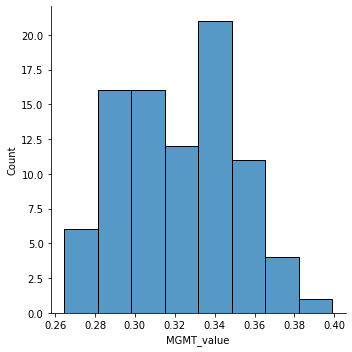

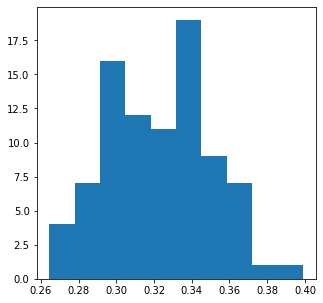

In [18]:
sns.displot(submission["MGMT_value"])
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value"]);